# Système de recommendation : premiers pas NLTK 

Ce notebook a pour but de présenter les premières observations que l'on obtient en regardant les commentaires des utilisateurs laissés aux jeux dans la base de donnée avis_clean.csv. Il se découpe en deux parties : le nettoyage (récupération des BDD pertinentes) et exposition des histogrammes.

In [27]:
# Importations pertinentes : filtering_text, bdd avis (à filtrer)
import pandas as pd
import numpy as np
from reco_systems.filter import filter_df
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.util import ngrams

from treetaggerwrapper import TreeTagger
from spellchecker import SpellChecker
import seaborn as sns

FR_stopwords = stopwords.words("french")
sns.set_theme()

In [28]:
#tagger = TreeTagger(TAGDIR="/Users/bsh2022/Downloads", TAGLANG="fr")

In [29]:
from unidecode import unidecode # remove french accents

In [16]:
# for word in FR_stopwords:
#     if "que" in word:
#         print(word)
#FR_stopwords += ['donc', 'alors', 'que', 'qui', 'car', 'parce']

In [3]:
folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", names=["Username", "User id"])

min_reviews = 10
rev_filter = filter_df(avis_clean, min_reviews)

df = rev_filter[['Game id', 'User id', 'Rating', 'Comment title', 'Comment body']].copy()

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


In [10]:
# .apply(unidecode) in the end if necessary (delete french accents)
text = rev_filter[["Comment title", "Comment body"]].apply(lambda x : " ".join(x.values.astype(str)), axis=1).str.lower().apply(unidecode)
text.head(10)

0     voyages sur les ailes des papillons lorsque le...
1     le festival de michoacan comment continuer apr...
2     vivez la migration des monarques vin d'jeu: av...
3     manque un peu de souffle mariposas est plutot ...
4     beau et doux et rapide mariposas est un jeu ou...
6     peut-etre pas uniquement familial il est tres ...
7     mysterium sans ses defauts vin d'jeu: ce << no...
8     chapeau l'artiste en famille nous avons bien p...
9     parc a theme j'ai eu l'occasion de jouer a des...
11    mysterium light fan de la serie mysterium c'es...
dtype: object

### Remove punctuation

In [12]:
#punc_to_delete = string.punctuation.replace("\'", "") # ' can have meaning?
punc_to_delete = string.punctuation
punc_to_delete

trans_table = str.maketrans(punc_to_delete, " " * len(punc_to_delete))
text = text.str.translate(trans_table)

### Remove French stopwords

In [18]:
text = text.apply(lambda x : " ".join([word for word in x.split() if word not in FR_stopwords]))

### Tokenization

In [19]:
text_df = text.to_frame().rename(columns={0 : "Text"})
text_df["Tokens"] = text.apply(lambda row: nltk.word_tokenize(row))
# text_df

In [20]:
tokens = text_df[["Tokens"]]
tokens

,Tokens
0,"[voyages, ailes, papillons, lorsque, jeu, jeu,..."
1,"[festival, michoacan, comment, continuer, apre..."
2,"[vivez, migration, monarques, vin, jeu, maripo..."
3,"[manque, peu, souffle, mariposas, plutot, beau..."
4,"[beau, doux, rapide, mariposas, jeu, tension, ..."
...,...
142459,"[piou, boum, badaboum, crac, re, piou, petit, ..."
142460,"[star, wars, revisite, jeu, vaisseau, spaciaux..."
142461,"[piou, piou, mag, blast, jeu, rapide, drole, s..."
142462,"[peewww, peeeww, mort, pu, jouer, a, 2, moyen,..."


In [21]:
words = tokens.explode("Tokens")
words["Len"] = words["Tokens"].str.len()
words = words[words["Len"] > 1]
words

,Tokens,Len
0,voyages,7
0,ailes,5
0,papillons,9
0,lorsque,7
0,jeu,3
...,...,...
142465,tres,4
142465,attrayant,9
142465,voir,4
142465,partie,6


### Replace repeating caracters

In [22]:
words["Tokens"] = words["Tokens"].str.replace(r"(.)\1+", r"\1", regex=True)
words[words["Len"] >= 35]

,Tokens,Len
3873,projetgarfieldsoutenuplusoumoinsvraimentpariel...,64
3873,sortirmaisbononeveutpasvexergarfieldalorsonyva...,83
4309,0498c8d916ad49814197846cadefc70a89f,36
6869,enquetescoperatifimersifmaterielbeaute,40
8755,wargh,45
...,...,...
131964,whoanon,35
137964,4f7f9c9170798ac31d37f461d7c76512a7,36
137964,4f7f9c9170798ac31d37f461d7c76512a7ps5,39
138712,cartesrejouabilitefraicheurprixpoints,37


### Remove hex-like words

In [23]:
# at least one digit and hex like structure
words = words[~words["Tokens"].str.match(r"^(?=.*\d)[a-z0-9]{20,}$", na=False)]

### Replace digits with ''

In [24]:
words["Tokens"] = words["Tokens"].str.replace(r'\d+', '', regex=True)

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_28281/2062898132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words["Tokens"] = words["Tokens"].str.replace(r'\d+', '', regex=True)


In [25]:
words[words["Tokens"].str.match(r"\d+")]

,Tokens,Len


In [26]:
# Recalc length 
words["Len"] = words["Tokens"].str.len()
words

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_28281/217479811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words["Len"] = words["Tokens"].str.len()


,Tokens,Len
0,voyages,7
0,ailes,5
0,papilons,8
0,lorsque,7
0,jeu,3
...,...,...
142465,tres,4
142465,atrayant,8
142465,voir,4
142465,partie,6


In [27]:
# limit words length
words = words[(words["Len"] > 1) & (words["Len"] < 25)]
words["Tokens"].value_counts()

Tokens
jeu              224273
plus              90753
tres              71701
bien              66651
tout              57262
                  ...  
denrier               1
laboraqualite         1
expliquerla           1
sympautre             1
chouraver             1
Name: count, Length: 96669, dtype: int64

### Lemmatization

In [ ]:
# stemming
# stemmer = FrenchStemmer()
# words["Stems"] = words["Tokens"].apply(stemmer.stem)
# words = words[~words["Stems"].isna()]
# words

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_28281/1798391041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  words["Stems"] = words["Tokens"].apply(stemmer.stem)


,Tokens,Len,Stems
0,voyages,7,voyag
0,ailes,5,ail
0,papilons,8,papilon
0,lorsque,7,lorsqu
0,jeu,3,jeu
...,...,...,...
142465,tres,4,tre
142465,atrayant,8,atrai
142465,voir,4,voir
142465,partie,6,part


In [21]:
lemmas = pd.read_csv("generated_data/lemmas.csv", index_col=0)
lemmas = lemmas[~lemmas["Lemma"].isna()]
lemmas

,Tokens,Len,Comment line,Word,Part of speech,Lemma
0,voyages,7,0,voyages,NOM,voyage
1,ailes,5,0,ailes,NOM,aile
2,papilons,8,0,papilons,NOM,papilon
3,lorsque,7,0,lorsque,KON,lorsque
4,jeu,3,0,jeu,NOM,jeu
...,...,...,...,...,...,...
6311928,tres,4,142465,tres,NOM,tres
6311929,atrayant,8,142465,atrayant,VER:ppre,atraire
6311930,voir,4,142465,voir,VER:infi,voir
6311931,partie,6,142465,partie,NOM,partie


Text(0.5, 0, '')

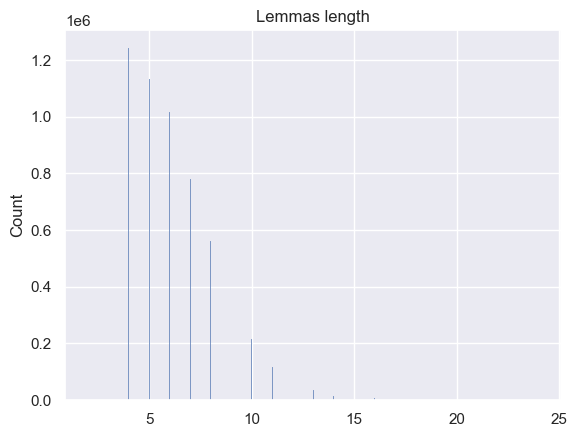

In [ ]:
length = lemmas["Lemma"].str.len().value_counts()
# ax = sns.histplot(data=lemmas["Lemma"].str.len())
# ax.set_title("Lemmas length")
# ax.set_xlabel("")

### Filter Part of speech (POS)

In [383]:
lemmas["Part of speech"] = lemmas["Part of speech"].str.replace(r":.*", '', regex=True)
lemmas["Part of speech"].value_counts()

Part of speech
NOM    3464254
VER    1138168
ADJ     702280
ADV     645719
PRO     203683
KON      46885
PRP      36507
NUM      35695
INT      29956
ABR       4526
DET       3758
NAM        502
Name: count, dtype: int64

In [384]:
lemmas[lemmas["Part of speech"] == "ADV"]["Lemma"].unique()

array(['encore', 'autrement', 'plus', 'pourtant', 'bien', 'alors',
       'simplement', 'surtout', 'peu', 'beaucoup', 'si', 'principalement',
       'vraiment', 'contrairement', 'vite', 'curieusement', 'lors',
       'souvent', 'environ', 'donc', 'uniquement', 'parfaitement',
       'typiquement', 'puis', 'tard', 'moins', 'maintenant', 'trop',
       'facilement', 'quand', 'parfois', 'avantageusement', 'grandement',
       'tant', 'mieux', 'exactement', 'ainsi', 'jamais', 'presque',
       'rapidement', 'ici', 'toujours', 'autour', 'purement',
       'positivement', 'franchement', 'finalement', 'cependant', 'enfin',
       'voire', 'loin', 'toutefois', 'inversement', 'pourquoi', 'ben',
       'non', 'seulement', 'bougrement', 'volontiers', 'partout',
       'autant', 'ci', 'gracieusement', 'relativement', 'malheureusement',
       'vivement', 'longtemps', 'ensuite', 'devant', 'largement',
       'clairement', 'comparativement', 'heureusement', 'quasi',
       'temporairement', 'certes'

In [385]:
pos_to_save = ["NOM", "VER", "ADJ"]
lemmas = lemmas[lemmas["Part of speech"].isin(pos_to_save)]

In [386]:
lemmas = lemmas[~lemmas["Lemma"].isna()]

In [39]:
words_imploded = lemmas.groupby(by="Comment line")['Lemma'].apply(list).reset_index(drop=True).to_frame().rename(columns={0 : "Lemma"})

In [41]:
words_imploded["Comment lemmatized"] = words_imploded["Lemma"].apply(lambda row : " ".join(row))
words_imploded

,Lemma,Comment lemmatized
0,"[voyage, aile, papilon, jeu, jeu, bon, reflexi...",voyage aile papilon jeu jeu bon reflexif joli ...
1,"[festival, michoacan, coment, continuer, apres...",festival michoacan coment continuer apres mega...
2,"[vivre, migration, monarque, vin, jeu, maripos...",vivre migration monarque vin jeu mariposer eli...
3,"[manque, peu, soufle, mariposer, plutot, beau,...",manque peu soufle mariposer plutot beau grand ...
4,"[beau, doux, rapide, mariposer, jeu, tension, ...",beau doux rapide mariposer jeu tension aller e...
...,...,...
96525,"[piou, re, piou, petit, jeu, bien, fun, falloi...",piou re piou petit jeu bien fun falloir faire ...
96526,"[star, wars, revisiter, jeu, vaiseau, spaciaux...",star wars revisiter jeu vaiseau spaciaux asez ...
96527,"[piou, piou, mag, blast, jeu, rapide, drole, p...",piou piou mag blast jeu rapide drole pretentio...
96528,"[pew, pew, mort, pouvoir, jouer, moyen, pouvoi...",pew pew mort pouvoir jouer moyen pouvoir fouil...


In [43]:
words_imploded[["Comment lemmatized"]].to_csv("generated_data/comments_lemm.csv")

In [387]:
freq = lemmas["Lemma"].value_counts().to_frame().reset_index()

In [388]:
merged = freq.merge(lemmas, on="Lemma")

In [389]:
# ADV_to_delete = merged[(merged["Part of speech"] == "ADV") & (merged["count"] > 500)]["Lemma"].unique()
# lemmas["Len lemma"] = lemmas["Lemma"].str.len()
# lemmas = lemmas[lemmas["Len lemma"] > 2]
# lemmas = lemmas[~lemmas["Lemma"].isin(ADV_to_delete)]
freq = lemmas["Lemma"].value_counts().to_frame().reset_index()

### Frequences graphics

In [390]:
freq

,Lemma,count
0,jeu,251638
1,faire,81116
2,tres,71701
3,pouvoir,59292
4,carte,56857
...,...,...
77530,ciardes,1
77531,rimtik,1
77532,vocabulistique,1
77533,fluidesla,1


In [ ]:
# low_idf_delete = ['bon', 'joueur', 'meme',
#        'jouer', 'petit', 'partir', 'partie', 'autre', 'etre',
#        'falloir', 'regles', 'come', 'joue', 'prendre', 'grand',
#        'dire', 'materiel', 'trouver', 'ausi', 'asez',  'car',
#        'point', 'theme', 'tour', 'voir', 'fois', 'temps', 'aller', 'cete',
#        'avoir', 'bone', 'coup', 'apres', 'seul',
#        'rapide', 'rien', 'bref', 'reste', 'gagner', 'savoir', 'devoir',
#        'boite', 'penser', 'chose',
#        'choix', 'fin', 'cote', 'plutot',
#        'rendre', 'moment', 
#        'vrai', 'sortir', 'place', 
#        'monde',  'part', 'deja', 'vouloir', 'avant',
#        'nombre', 'base', 'permettre',
#        'mettre', 'pase', 'ete', 'gros', 'comprendre',
#        'voiler', 'avis', 'premiere']
# lemmas = lemmas[~lemmas["Lemma"].isin(low_idf_delete)]

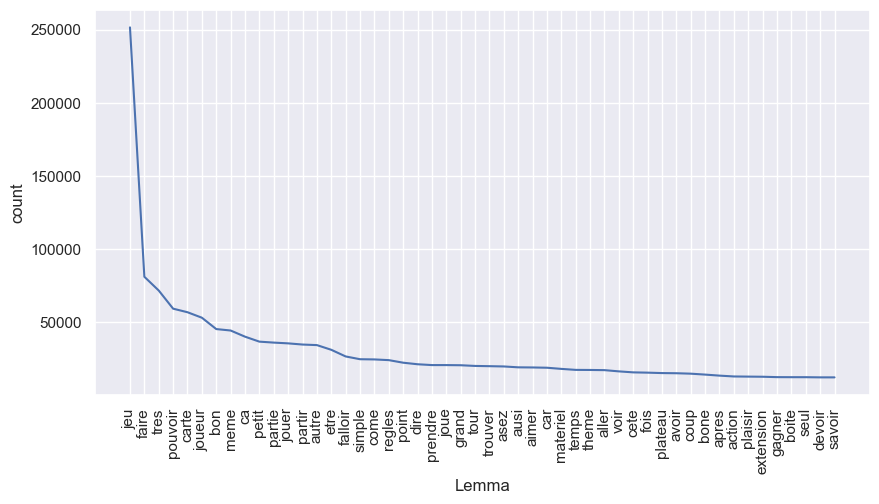

In [392]:
sns.set_theme(rc={'figure.figsize' : (10, 5)})
lim_freq = freq[:50]
ax = sns.lineplot(data=lim_freq, x="Lemma", y="count")
ax.tick_params(axis='x', rotation=90)

### Borne min d'apparition d'un mot (>= 5)

In [ ]:
rare_lemmas = freq[freq["count"] < 5]["Lemma"]
# unnec_lemmas = ["donc", "onc", "genre", "cas", "prix", "eret", "ide", "type", "heure", "phase", "essayer", "permetent", 
#                 "minute", "compte", "facon", "prise", "ailleurs", "eles", "bele", "arive", "done", "version", "etait", "regle", 
#                 "mettre", "choisir", "utiliser", "aler", "alez", "etant", "laise", "exemple", "egalement", 
#                 ] # 'trash' words 
# pipes = lemmas[lemmas["Lemma"].str.contains(r'\|', regex=True)]["Lemma"].values

# lemmas = lemmas[~lemmas["Lemma"].isin(rare_lemmas)]
# lemmas = lemmas[~lemmas["Lemma"].isin(unnec_lemmas)]
# lemmas = lemmas[~lemmas["Lemma"].isin(pipes)]

lemmas["Lemma"].value_counts()

Lemma
jeu           251638
faire          81116
tres           71701
pouvoir        59292
carte          56857
               ...  
contextuel         5
pubic              5
titrer             5
memeles            5
peripetie          5
Name: count, Length: 22355, dtype: int64

### Borne sur la limite de len des mots

In [451]:
length = lemmas["Lemma"].str.len()
short_words = lemmas[length == 2]["Lemma"].unique()
lemmas = lemmas[~lemmas["Lemma"].isin(short_words)]
lemmas["Lemma"].nunique()

14554

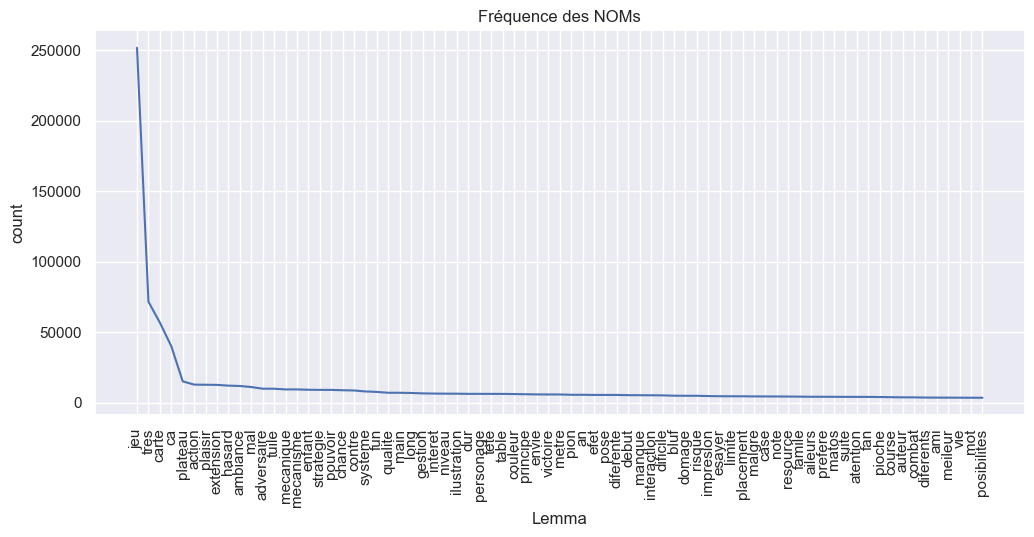

In [394]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
freq_nom = lemmas[lemmas["Part of speech"] == "NOM"][["Lemma"]].value_counts().reset_index()
ax = sns.lineplot(data = freq_nom.head(75), x = "Lemma", y="count")
ax.tick_params(axis='x', rotation=90)
ax.set_title("Fréquence des NOMs")
freq = lemmas["Lemma"].value_counts().to_frame().reset_index()

Text(0.5, 1.0, 'Fréquence des VERbes')

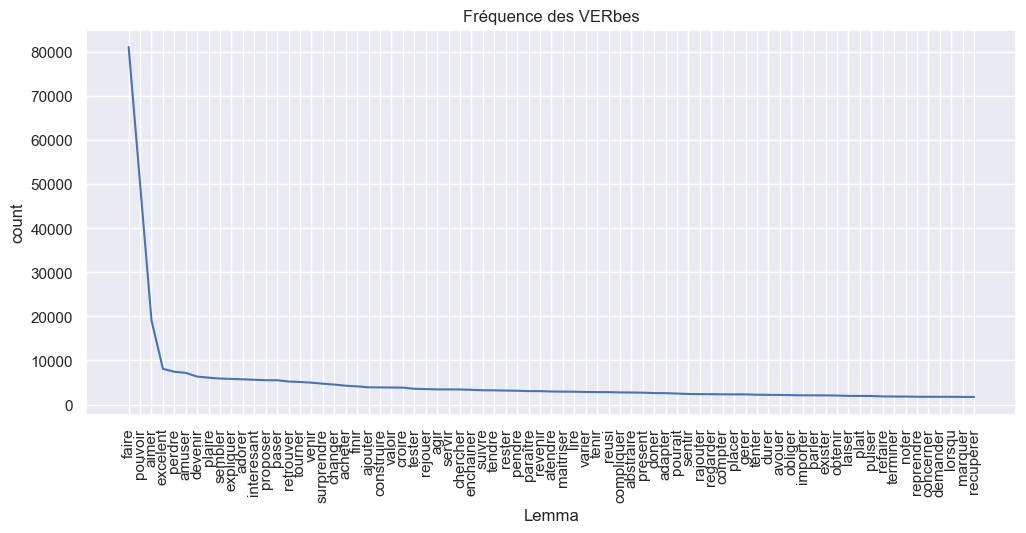

In [426]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
freq_nom = lemmas[lemmas["Part of speech"] == "VER"][["Lemma"]].value_counts().reset_index()
ax = sns.lineplot(data = freq_nom.head(75), x = "Lemma", y="count")
ax.tick_params(axis='x', rotation=90)
ax.set_title("Fréquence des VERbes")

In [440]:
rare_verbs = lemmas[lemmas["Part of speech"] == "VER"]["Lemma"].value_counts().reset_index().sort_values("count").head(100)
verbs_counts = lemmas[lemmas["Part of speech"] == "VER"]["Lemma"].value_counts().reset_index()
rare_verbs = verbs_counts[verbs_counts["count"] < 15]["Lemma"].values

In [ ]:
verbs_to_keep = ['afaiblir', 'super',
       'deranger', 'nenfant', 'racrocher', 'defaire', 'demenager',
       'teraformer', 'decouvrir', 'panacher', 'predire', 'agrementer',
       'suplanter', 'aparenter', 'sprinter', 'slever', 'manager',
       'degrader', 'inocenter', 'racorder', 'cocher', 'player', 'edifier',
       'demonter', 'denicher', 'feliciter', 'aranger', 'emouvoir',
       'amenager', 'desavantager', 'stoper', 'deconstruire', 'acrocher',
       'demerder', 'clocher', 'depeindre', 'deployer', 'frequenter',
       'eforcant', 'exhorbiter', 'reguler', 'considerent', 'aerer',
       'temoigner', 'aculer', 'enuyez', 'aprecierais', 'afranchir',
       'resumait', 'ramasez', 'regata', 'quitera', 'compla', 'abandonant',
       'colez', 'munisez', 'barent', 'subodorer', 'poluent', 'majorer',
       'iritant', 'retransmettre', 'demotiver', 'donerez']

Text(0.5, 1.0, 'Fréquence des ADJectives')

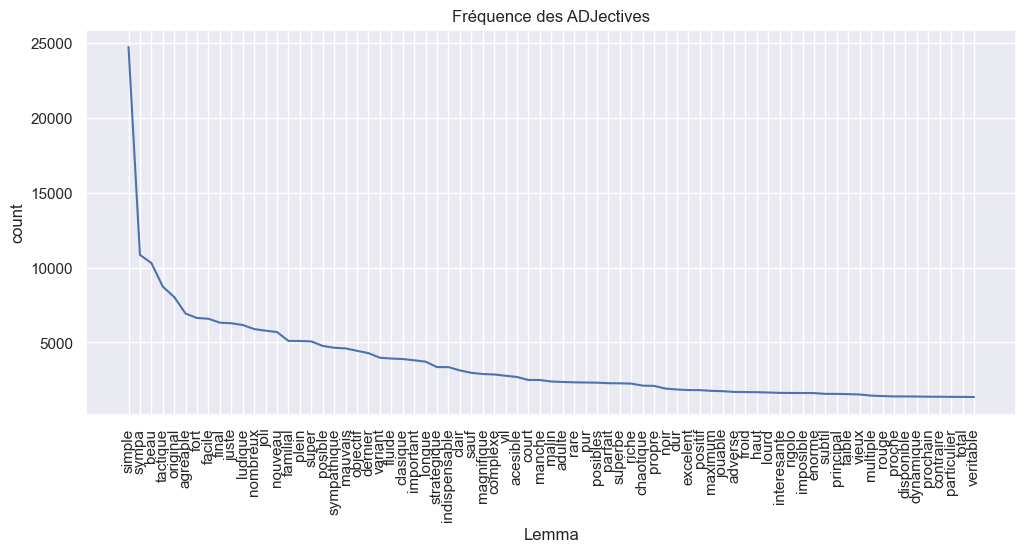

In [396]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
freq_nom = lemmas[lemmas["Part of speech"] == "ADJ"][["Lemma"]].value_counts().reset_index()
ax = sns.lineplot(data = freq_nom.head(75), x = "Lemma", y="count")
ax.tick_params(axis='x', rotation=90)
ax.set_title("Fréquence des ADJectives")

In [425]:
lemmas["Lemma"].unique()[:100]

array(['voyage', 'aile', 'papilon', 'jeu', 'reflexif', 'joli', 'sensible',
       'style', 'ilustration', 'envie', 'rejouer', 'esayer', 'revivre',
       'histoire', 'lorsqu', 'detour', 'interese', 'propos', 'legere',
       'amene', 'efectivement', 'tres', 'ludiquement', 'parler',
       'posible', 'areter', 'ouverture', 'œil', 'entourer', 'ca',
       'festival', 'coment', 'continuer', 'mega', 'hit', 'oiseau',
       'principe', 'pourait', 'qualifier', 'familial', 'avancer', 'carte',
       'pays', 'aterir', 'fleur', 'colectioner', 'reproduire', 'marquer',
       'pouvoir', 'vil', 'glaner', 'couleur', 'dificile', 'pose', 'jeton',
       'aleatoire', 'complexifier', 'coler', 'objectif', 'saison',
       'revenir', 'depart', 'adulte', 'transformation', 'force',
       'deployer', 'chercher', 'realiser', 'mase', 'rester', 'pres',
       'abstraire', 'hasardeux', 'tirage', 'fastidieux', 'repetitif',
       'mecanique', 'original', 'cele', 'vivre', 'migration', 'vin',
       'mariposer', 

### TF IDF

In [22]:
comments = lemmas.groupby(by="Comment line")['Lemma'].apply(list).reset_index(drop=True).to_frame().rename(columns={0 : "Lemma"})
comments["Text"] = comments["Lemma"].apply(" ".join)

In [456]:
vect = TfidfVectorizer()
tfidf_matrix = vect.fit_transform(comments["Text"])

In [402]:
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3261834 stored elements and shape (96513, 22354)>

In [404]:
lemmas_idf = pd.DataFrame.from_dict(data=dict(zip(vect.get_feature_names_out(), vect.idf_)), orient="index").reset_index().rename(columns={"index" : "Lemma", 0 : "IDF"})

Text(0.5, 1.0, 'Lemmatized words IDF distribution')

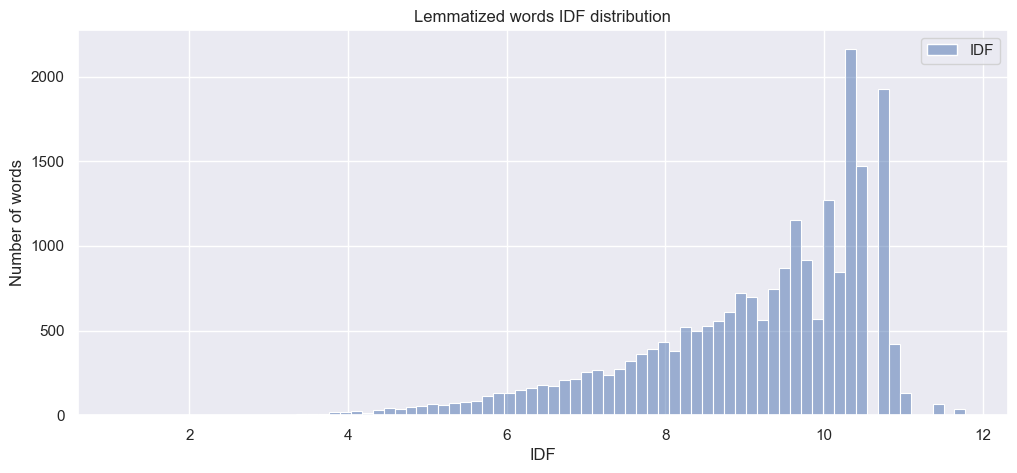

In [ ]:
sns.set_theme()
ax = sns.histplot(lemmas_idf)
ax.set_xlabel("IDF")
ax.set_ylabel("Number of words")
ax.set_title("Lemmas IDF distribution")

In [406]:
merged = lemmas_idf.merge(freq[["Lemma", "count"]], on="Lemma").sort_values(by="IDF", ascending=False)

In [ ]:
#merged[merged["count"] == 100].head(50)
# top_idf = merged.sort_values(by="IDF", ascending=False).head(50)
# top_idf
# lemmas_to_delete = merged[(merged["IDF"] > 10) & (merged["count"] <= 13)]["Lemma"].values
#lemmas = lemmas[~lemmas["Lemma"].isin(lemmas_to_delete)]
#lemmas["Lemma"].unique()

array(['voyage', 'aile', 'papilon', ..., 'mamba', 'shendao', 'oselets'],
      dtype=object)

In [408]:
merged.sort_values(by="IDF")[100:200]["IDF"].values

array([4.20003136, 4.23205889, 4.23337208, 4.23442389, 4.23653081,
       4.24953352, 4.25381618, 4.29712248, 4.29824356, 4.29964667,
       4.30020847, 4.31806862, 4.31864086, 4.32553348, 4.32841949,
       4.32928691, 4.33654489, 4.3462068 , 4.34915318, 4.35388552,
       4.36731655, 4.36882009, 4.37002454, 4.37697846, 4.37788907,
       4.38275971, 4.38428666, 4.38520395, 4.38888155, 4.39535008,
       4.40591246, 4.41375072, 4.41879964, 4.41911605, 4.41943255,
       4.42196821, 4.42260313, 4.4241922 , 4.42993384, 4.43538694,
       4.44508321, 4.44735926, 4.45454648, 4.45454648, 4.45651564,
       4.467748  , 4.46974334, 4.47040934, 4.47575338, 4.47675857,
       4.48179975, 4.48382336, 4.48585107, 4.48890037, 4.49366229,
       4.49639359, 4.49810446, 4.50291051, 4.50739405, 4.50773977,
       4.51016318, 4.51155062, 4.51224506, 4.51467942, 4.51921616,
       4.51991595, 4.52061623, 4.52272002, 4.52307108, 4.52976478,
       4.53295119, 4.5389978 , 4.54185597, 4.5450812 , 4.54759

### 3igrams

In [31]:
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures

In [ ]:
# vect = TfidfVectorizer(ngram_range=(3, 3))
# tfidf_matrix = vect.fit_transform(comments["Text"])
# vect.get_feature_names_out()

In [ ]:
trigram_finder = TrigramCollocationFinder.from_documents(comments["Lemma"].to_list())
trigram_pmi = trigram_finder.score_ngrams(TrigramAssocMeasures.pmi)
trigrams_df = pd.DataFrame(data=[list(info) for info in trigram_pmi])
trigrams_df[0] = trigrams_df[0].apply(list)
trigrams_df = trigrams_df.rename(columns={0:"trigram", 1:"pmi"})
trigrams_df

,0,1
0,"[Gou, Ming, hasarahaYan]",45.179243
1,"[Ming, hasarahaYan, waba]",45.179243
2,"[Shen, dearu, sayumichiyan]",45.179243
3,"[abordablesimple, posiblebel, objetles]",45.179243
4,"[abxy, ll, rr]",45.179243
...,...,...
4892141,"[jeu, jeu, autre]",-5.772103
4892142,"[ca, jeu, jeu]",-5.995742
4892143,"[jeu, jeu, ca]",-5.995742
4892144,"[jeu, jeu, jeu]",-6.321799


In [37]:
trigrams_df.sort_values(by="pmi", ascending=False).head(50)

,trigram,pmi
0,"[Gou, Ming, hasarahaYan]",45.179243
113,"[legereregles, clairesrapide, jouerdes]",45.179243
143,"[orb, necropotence, blinking]",45.179243
144,"[originaltransportablepeu, cherjouable, nombre...",45.179243
145,"[ortan, casius, chapelain]",45.179243
146,"[oumba, zounga, bouloum]",45.179243
147,"[pajot, kersauson, riguidel]",45.179243
148,"[paleysi, castelan, estcet]",45.179243
149,"[pariesilustration, plaisantesmecanisme, sympa...",45.179243
150,"[partich, jouech, navegadoch]",45.179243


In [ ]:
sns.histplot(data=bigrams_df_exp.groupby(by="bigram").max().reset_index().sort_values(by="pmi", ascending=False).head(50))
trigrams_df_exp = trigrams_df[["pmi", "bigram"]].explode("bigram")


### Bigrams

In [ ]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

In [412]:
bigram_finder = BigramCollocationFinder.from_documents(comments["Lemma"].to_list())

In [413]:
bigram_pmi = bigram_finder.score_ngrams(BigramAssocMeasures.pmi)

In [414]:
bigrams_df = pd.DataFrame(data=[list(info) for info in bigram_pmi])
bigrams_df[0] = bigrams_df[0].apply(list)

In [415]:
bigrams_df[["Lemma 1", "Lemma 2"]] = pd.DataFrame(data=bigrams_df[0].tolist(), index=bigrams_df.index)
bigrams_df = bigrams_df.rename(columns={0:"bigram", 1:"pmi"})

In [ ]:
sorted = bigrams_df.sort_values(by="pmi")
bigrams_df_exp = bigrams_df[["pmi", "bigram"]].explode("bigram")
bigrams_df_exp.groupby(by="bigram").max().reset_index().sort_values(by="pmi", ascending=False).head(50)

Text(0.5, 1.0, 'Bigrams PMI distribution')

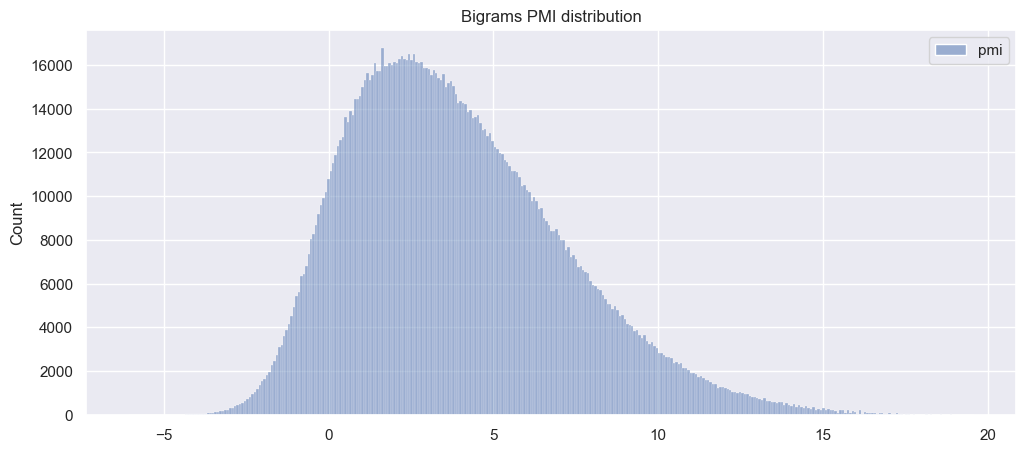

In [ ]:
ax = sns.histplot(data=bigrams_df_exp.groupby(by="bigram").max().reset_index().sort_values(by="pmi", ascending=False).head(50))
ax.set_title("Bigrams PMI distribution")

In [418]:
# words like blo blo, waf waf, afa afa
lemmas_to_delete = bigrams_df[((bigrams_df["Lemma 1"]) == (bigrams_df["Lemma 2"])) & (bigrams_df["pmi"] > 15)]["Lemma 1"].values
lemmas = lemmas[~lemmas["Lemma"].isin(lemmas_to_delete)]

In [462]:
sorted = bigrams_df.sort_values(by="pmi")
bigrams_df_exp = bigrams_df[["pmi", "bigram"]].explode("bigram")
bigrams_df_exp.groupby(by="bigram").max().reset_index().sort_values(by="pmi", ascending=False).head(50)

,bigram,pmi
6921,easter,19.583589
4906,couci,19.583589
4903,couca,19.583589
7197,egs,19.583589
6412,dicke,19.583589
12720,luft,19.583589
16253,poulp,19.320554
2961,byoskop,19.320554
20868,tohu,19.320554
22014,wabohu,19.320554


In [229]:
l1 = top_idf.merge(bigrams_df, left_on="Lemma", right_on="Lemma 1")
l2 = top_idf.merge(bigrams_df, left_on="Lemma", right_on="Lemma 2")


In [236]:
bigrams_df[["Lemma 1", "pmi"]].groupby("Lemma 1").mean().reset_index().sort_values(by="pmi", ascending=True).head(50).merge(top_idf, left_on="Lemma 1", right_on="Lemma").sort_values(by="count", ascending=True)

,Lemma 1,pmi,Lemma,IDF,count
35,reste,1.182124,reste,3.215774,12076
23,rapide,0.971387,rapide,3.185463,12118
29,rien,1.088328,rien,3.201721,12307
17,seul,0.914809,seul,3.173646,12438
34,gagner,1.179963,gagner,3.245466,12482
31,plaisir,1.156403,plaisir,3.153185,12838
27,apres,1.057249,apres,3.124600,13510
21,bone,0.948190,bone,3.047289,14215
37,plateau,1.195423,plateau,3.123127,15255
32,fois,1.164197,fois,3.011036,15545


In [228]:
l1[l1["pmi"] < 0]

,Lemma,pmi
4501,jeu,-0.002407
4502,jeu,-0.002721
4503,jeu,-0.004409
4504,jeu,-0.004409
4505,jeu,-0.004601
...,...,...
162092,devoir,-5.626136
162093,devoir,-5.643706
162094,devoir,-5.735472
162095,devoir,-5.984510
